# Traffic Sign Classification Using Classical Digital Image Processing Techniques
Aiza Ali (22i-0612) | Malaika Saleem (22i-0509) | Hafsa Siddiqua (22i-0542) | Uriba Parveen (22i-0465) 

## Importing Libraries

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import PIL
from PIL import Image
import seaborn as sns

## Dataset Loading

### Chosen Classes
- Class 0 : Speed Limit 20 (prohibitory)
- Class 9:  No Overtaking (prohibitory)
- Class 12: Priority Road (other)
- Class 14: Stop (other)
- Class 17: No Entry (other)
- Class 27: Pedestrian Crossing (danger)
- Class 33: Go Right (mandatory)
- Class 40: Roundabout (mandatory)


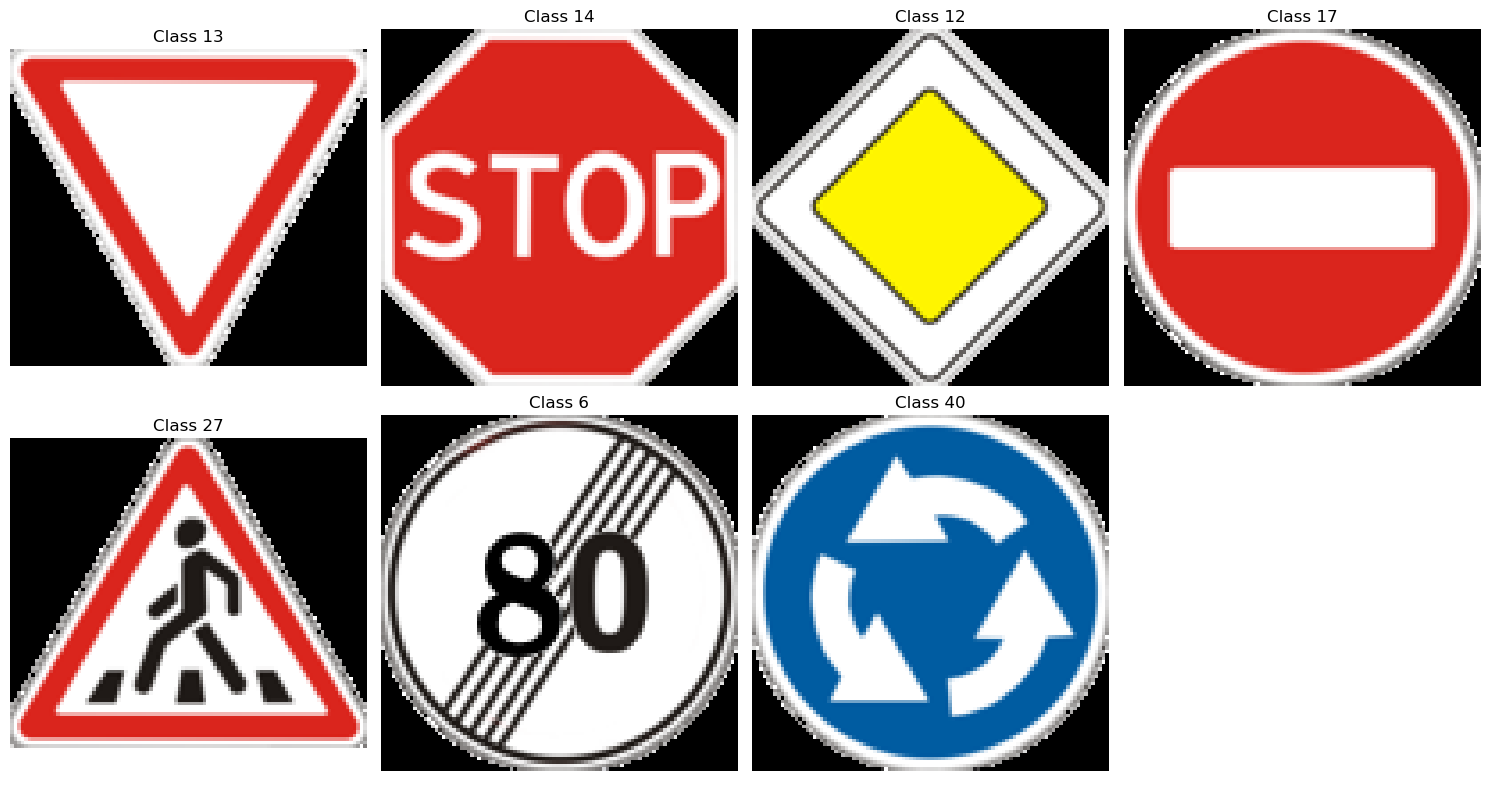

In [3]:
# Define the path to the Meta folder
meta_path = 'archive/Meta'
selected_classes = [13, 14, 12, 17, 27, 6, 40]

# Number of rows and columns for the grid
rows, cols = 2, 4
fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
axes = axes.flatten()

# Iterate through the selected classes
for idx, class_id in enumerate(selected_classes):
    image_filename = f'{class_id}.png'
    image_path = os.path.join(meta_path, image_filename)

    # Read the image using OpenCV
    image = cv2.imread(image_path)

    if image is not None:
        # Convert the image from BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Display the image in the grid
        axes[idx].imshow(image_rgb)
        axes[idx].set_title(f'Class {class_id}')
        axes[idx].axis('off')
    else:
        axes[idx].set_title(f'Class {class_id} not found')
        axes[idx].axis('off')

# Hide any unused subplots
for ax in axes[len(selected_classes):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [4]:
# Define the path to your dataset
dataset_path = "archive/"
train_path = os.path.join(dataset_path, "train")
meta_path = os.path.join(dataset_path, "meta")
test_path = os.path.join(dataset_path, "test")

# Read the CSV files
meta_df = pd.read_csv(os.path.join("archive/Meta.csv"))
train_df = pd.read_csv(os.path.join ("archive/Train.csv"))
test_df = pd.read_csv(os.path.join( "archive/Test.csv"))

# Define the selected class IDs (based on our previous discussion)
selected_classes = [13, 14, 12, 17, 27,6, 40]

# Filter the train DataFrame to include only the selected classes
filtered_train_df = train_df[train_df["ClassId"].isin(selected_classes)]

# Create a dictionary to store the loaded images and their class IDs
loaded_images = {}

# Load images for the selected classes
for index, row in filtered_train_df.iterrows():
    image_path = os.path.join(train_path, row["Path"])
    class_id = row["ClassId"]
    
    # Read the image using OpenCV
    image = cv2.imread(image_path)
    
    # Store the image and class ID in the dictionary
    if class_id not in loaded_images:
        loaded_images[class_id] = []
    loaded_images[class_id].append(image)

print(train_df.head())

KeyboardInterrupt: 

### Separate All Selected Classes

In [ ]:
# Create separate DataFrames for the 8 selected classes
train_class_13_df = train_df[train_df['ClassId'] == 13]
train_class_14_df = train_df[train_df['ClassId'] == 14]
train_class_12_df = train_df[train_df['ClassId'] == 12]
train_class_17_df = train_df[train_df['ClassId'] == 17]
train_class_27_df = train_df[train_df['ClassId'] == 27]
train_class_6_df  = train_df[train_df['ClassId'] == 6]
train_class_40_df = train_df[train_df['ClassId'] == 40]

# Example: Display the first few rows of one of the DataFrames
print('Class 12 DataFrame:')
train_class_12_df.tail()

## Preprocessing and Filtering 

 ### Mean Filter (3×3)
 (Brief Description of how it works)

In [5]:
def mean_filter(image):
    # Convert image to float for accurate calculations
    image = image.astype(np.float32) / 255.0
    
    # Define a 3x3 mean kernel
    kernel = np.ones((3, 3), dtype=np.float32) / 9.0
    
    # Pad the image to handle borders
    padded_image = np.pad(image, ((1, 1), (1, 1), (0, 0)), mode='reflect')
    
    # Apply the mean filter
    filtered_image = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for c in range(image.shape[2]):
                filtered_image[i, j, c] = np.sum(padded_image[i:i+3, j:j+3, c] * kernel)
    
    # Convert back to uint8
    return (filtered_image * 255).astype(np.uint8)

### Gaussian Filter (with standard deviation) 
(Brief Description of how it works)

In [6]:
def gaussian_filter(image, sigma=1.0):
    # Convert image to float
    image = image.astype(np.float32) / 255.0
    
    # Define a 3x3 Gaussian kernel
    size = 3
    kernel = np.zeros((size, size), dtype=np.float32)
    center = size // 2
    
    for i in range(size):
        for j in range(size):
            x, y = i - center, j - center
            kernel[i, j] = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel /= np.sum(kernel)
    
    # Pad the image
    padded_image = np.pad(image, ((1, 1), (1, 1), (0, 0)), mode='reflect')
    
    # Apply the Gaussian filter
    filtered_image = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for c in range(image.shape[2]):
                filtered_image[i, j, c] = np.sum(padded_image[i:i+3, j:j+3, c] * kernel)
    
    # Convert back to uint8
    return (filtered_image * 255).astype(np.uint8)

### Median Filter
(Brief Description of how it works)

In [7]:
def median_filter(image):
    # Pad the image
    padded_image = np.pad(image, ((1, 1), (1, 1), (0, 0)), mode='reflect')
    
    # Apply the median filter
    filtered_image = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for c in range(image.shape[2]):
                patch = padded_image[i:i+3, j:j+3, c]
                filtered_image[i, j, c] = np.median(patch)
    
    return filtered_image.astype(np.uint8)

 ### Adaptive Median Filter
 (Brief Description of how it works)

In [8]:
def adaptive_median_filter(image, max_size=7):
    # Pad the image with max_size//2 to handle the largest window
    pad_size = max_size // 2
    padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='reflect')
    
    filtered_image = np.copy(image).astype(np.uint8)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for c in range(image.shape[2]):
                # Start with a small window and increase up to max_size
                for window_size in range(3, max_size + 1, 2):
                    half_size = window_size // 2
                    patch = padded_image[i:i+window_size, j:j+window_size, c]
                    
                    # Compute median, min, and max of the patch
                    med = np.median(patch)
                    mn = np.min(patch)
                    mx = np.max(patch)
                    
                    # If the center pixel is an impulse noise, replace it with the median
                    if not (mn < padded_image[i+half_size, j+half_size, c] < mx):
                        filtered_image[i, j, c] = med
                        break  # No need to check larger windows
    
    return filtered_image

### Unsharp Masking and/or High-Boost Filtering
(Brief Description of how it works)

In [9]:
def unsharp_masking(image, sigma=1.0, strength=1.0):
    # Convert image to float
    image = image.astype(np.float32) / 255.0
    
    # Apply Gaussian blur
    blurred = gaussian_filter((image * 255).astype(np.uint8), sigma).astype(np.float32) / 255.0
    
    # Compute the high-pass image
    high_pass = image - blurred
    
    # Combine the original image with the high-pass image
    sharpened = image + strength * high_pass
    
    # Clip values to [0, 1] and convert back to uint8
    sharpened = np.clip(sharpened, 0, 1)
    return (sharpened * 255).astype(np.uint8)

### Filter Checkpoint

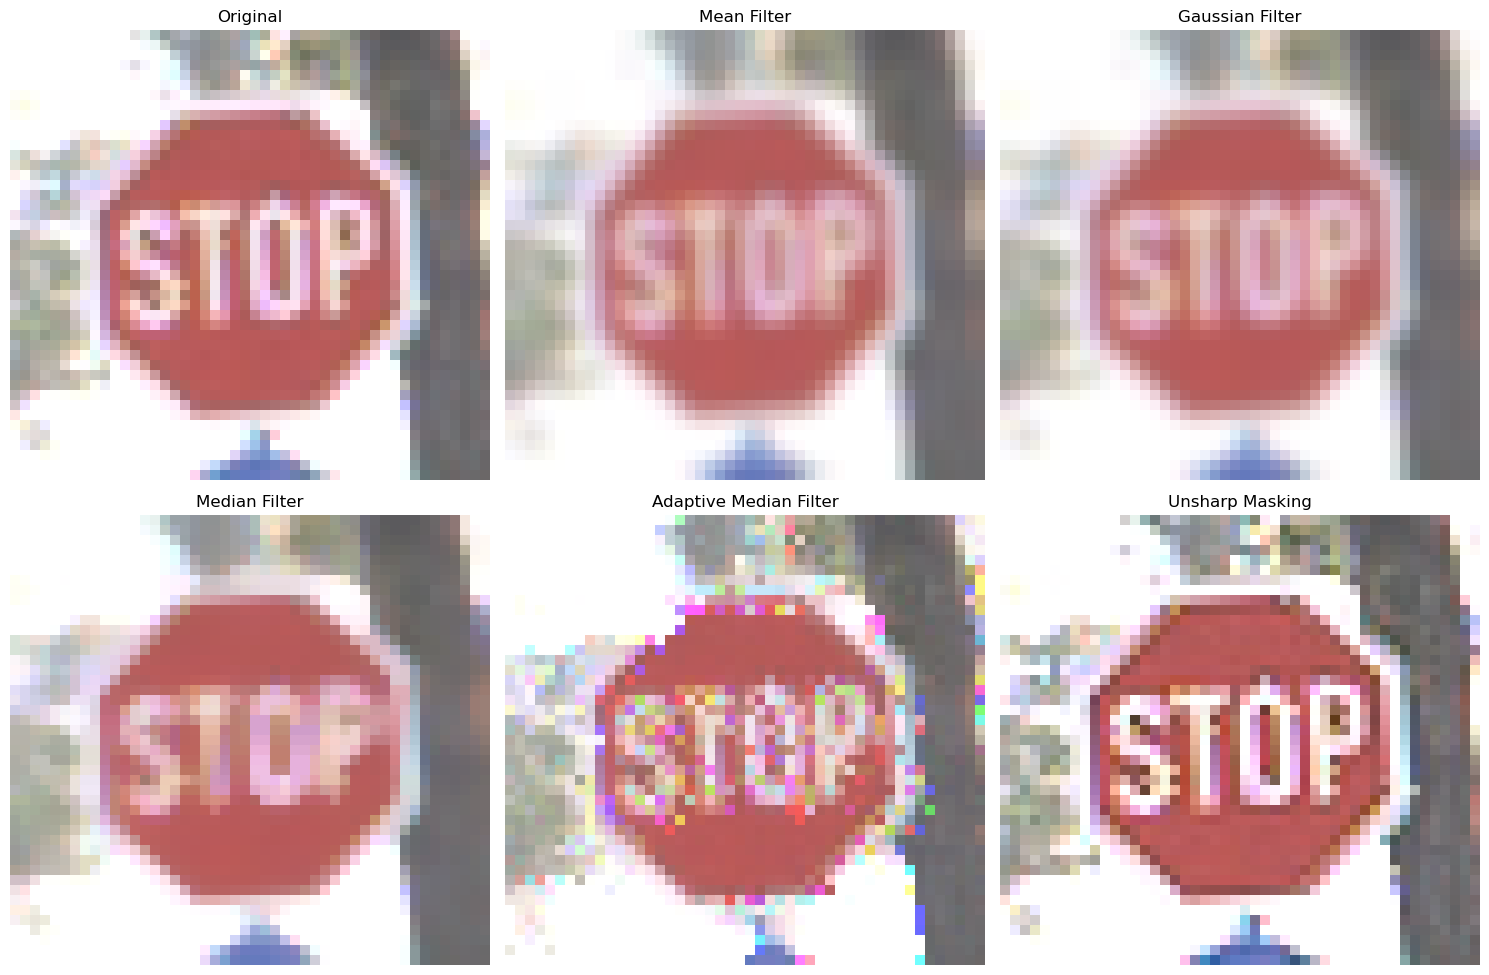

In [11]:
import matplotlib.pyplot as plt

# Select an image from class 0 (example: first image in the loaded_images for class 0)

sample_image = train_class_14_df.iloc[0]["Path"]
sample_image_path = os.path.join(dataset_path, sample_image)

# Load the image using OpenCV
sample_image_array = cv2.imread(sample_image_path)

# Apply filters to the sample image
mean_filtered = mean_filter(sample_image_array)
gaussian_filtered = gaussian_filter(sample_image_array, sigma=1.0)
median_filtered = median_filter(sample_image_array)
adaptive_median_filtered = adaptive_median_filter(sample_image_array)
unsharp_filtered = unsharp_masking(sample_image_array, sigma=1.0, strength=1.0)

# Create a list of images and their titles
images = [
    ("Original", sample_image_array),
    ("Mean Filter", mean_filtered),
    ("Gaussian Filter", gaussian_filtered),
    ("Median Filter", median_filtered),
    ("Adaptive Median Filter", adaptive_median_filtered),
    ("Unsharp Masking", unsharp_filtered)
]

# Create a grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, (title, img) in zip(axes, images):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

##  Color Space Conversion and Segmentation

### Convert RGB images to HSV color space manually or using PIL.

### Post Processing
* Binary mask thresholding
* Morphological operations (erosion, dilation, opening)
* Noise removal via connected component filtering (area threshold)
* Hole filling

#### Manual Conversion

Center region HSV statistics:
Hue range: 33.6–45.8, mean: 39.3
Saturation range: 0.550–0.773, mean: 0.725
Value range: 0.314–0.384, mean: 0.360
Blue area (post-processed): 899
Red area (post-processed): 200
Yellow area (post-processed): 1928
Dominant color: Yellow


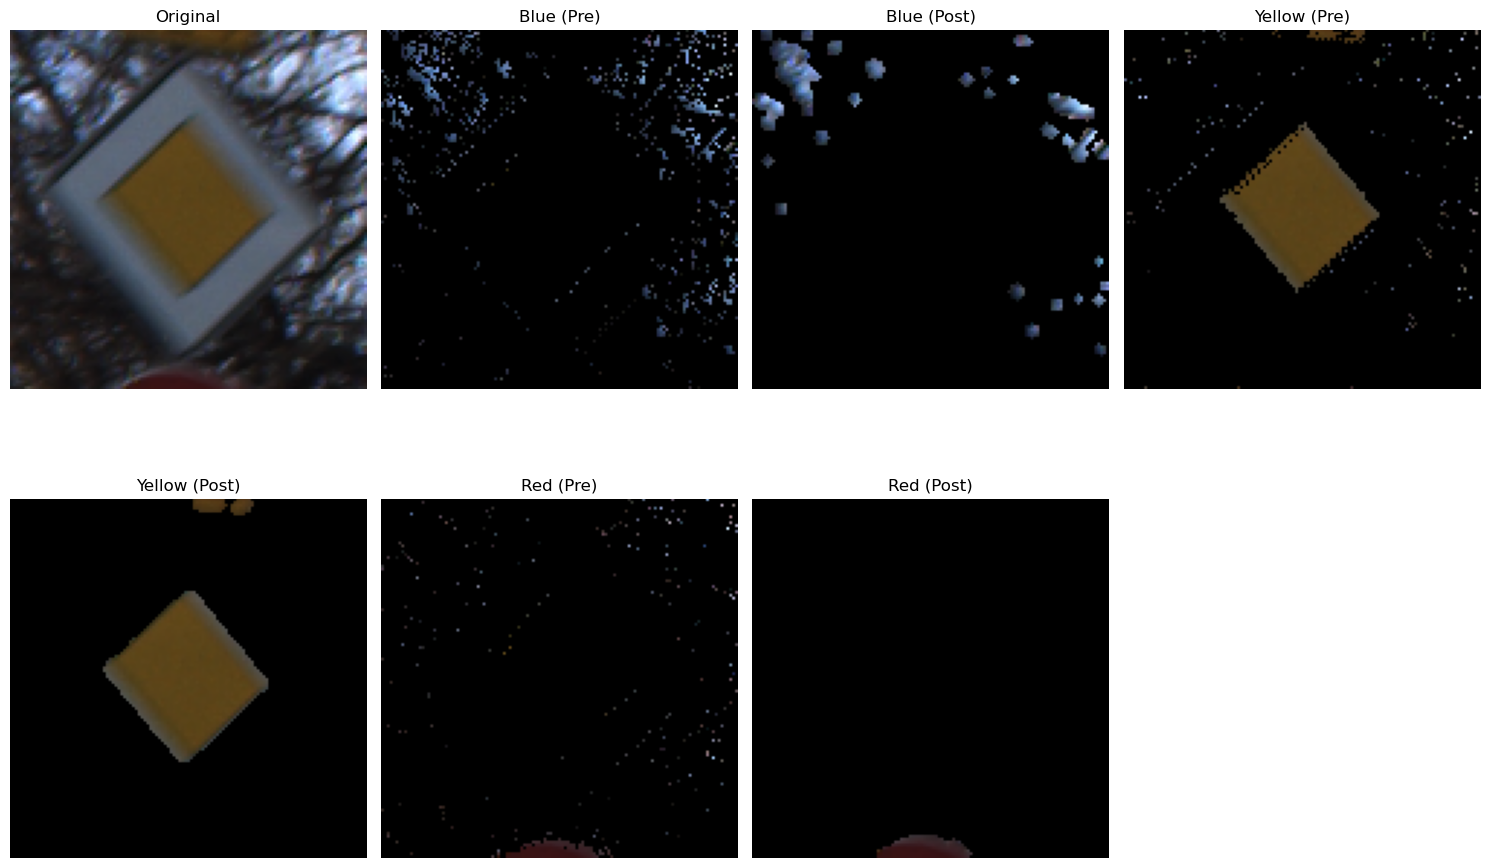

Processed: 00033_00000_00027 (Class 33)
Result (0 for red dominant, 1 for blue dominant,2 for yellow dominant): 2


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label
from PIL import Image
import os
#from preprocessing import adaptive_median_filter, unsharp_masking
# Define a custom structuring element (e.g., cross-shaped)
cross_structuring_element = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
])

def process_traffic_sign(image):
    """
    Process a single traffic sign image: preprocess, segment blue/red in HSV, post-process manually, and visualize.
    
    Args:
        image (numpy.ndarray): Input RGB image (H, W, 3) with values in [0, 255]
        skip_preprocessing (bool): If True, skip adaptive median filter and unsharp masking
    
    Returns:
        int: 0 if red segment is dominant, 1 if blue segment is dominant
    """
    processed_img = adaptive_median_filter(image)
    processed_img = unsharp_masking(processed_img, sigma=1.0, strength=1.0)
    
    # Manual RGB to HSV conversion
    def rgb_to_hsv_manual(rgb_img):
        rgb_img = rgb_img.astype(float) / 255.0
        r, g, b = rgb_img[:, :, 0], rgb_img[:, :, 1], rgb_img[:, :, 2]
        hsv_img = np.zeros_like(rgb_img)
        v = np.max(rgb_img, axis=2)
        min_val = np.min(rgb_img, axis=2)
        delta = v - min_val
        s = np.zeros_like(v)
        mask = v != 0
        s[mask] = delta[mask] / v[mask]
        h = np.zeros_like(v)
        mask_delta = delta != 0
        mask_r = (v == r) & mask_delta
        h[mask_r] = 60 * ((g[mask_r] - b[mask_r]) / delta[mask_r]) % 360
        mask_g = (v == g) & mask_delta
        h[mask_g] = 60 * ((b[mask_g] - r[mask_g]) / delta[mask_g] + 2)
        mask_b = (v == b) & mask_delta
        h[mask_b] = 60 * ((r[mask_b] - g[mask_b]) / delta[mask_b] + 4)
        hsv_img[:, :, 0], hsv_img[:, :, 1], hsv_img[:, :, 2] = h, s, v
        return hsv_img
    
    hsv_img = rgb_to_hsv_manual(processed_img)
    
    # Sample HSV values from a small central region (likely blue)
    h, w = hsv_img.shape[:2]
    center_region = hsv_img[h//2-h//10:h//2+h//10, w//2-w//10:w//2+w//10]  # Central 10%
    hues = center_region[:, :, 0].flatten()
    sats = center_region[:, :, 1].flatten()
    vals = center_region[:, :, 2].flatten()
    print("Center region HSV statistics:")
    print(f"Hue range: {np.min(hues):.1f}–{np.max(hues):.1f}, mean: {np.mean(hues):.1f}")
    print(f"Saturation range: {np.min(sats):.3f}–{np.max(sats):.3f}, mean: {np.mean(sats):.3f}")
    print(f"Value range: {np.min(vals):.3f}–{np.max(vals):.3f}, mean: {np.mean(vals):.3f}")
    
#     # Visualize HSV channels
#     plt.figure(figsize=(15, 5))
#     plt.subplot(1, 3, 1)
#     plt.title("Hue")
#     plt.imshow(hsv_img[:, :, 0], cmap='hsv')
#     plt.colorbar(label='Degrees')
#     # Draw rectangle for sampled region
#     rect = plt.Rectangle((w//2-w//10, h//2-h//10), 2*w//10, 2*h//10, linewidth=2, edgecolor='white', facecolor='none')
#     plt.gca().add_patch(rect)
#     plt.axis('off')
#     plt.subplot(1, 3, 2)
#     plt.title("Saturation")
#     plt.imshow(hsv_img[:, :, 1], cmap='gray')
#     plt.colorbar()
#     plt.axis('off')
#     plt.subplot(1, 3, 3)
#     plt.title("Value")
#     plt.imshow(hsv_img[:, :, 2], cmap='gray')
#     plt.colorbar()
#     plt.axis('off')
#     plt.tight_layout()
#     plt.show()
    
    # Segment blue and red regions
    def segment_blue_red(hsv_img):
        h, s, v = hsv_img[:, :, 0], hsv_img[:, :, 1], hsv_img[:, :, 2]
        # Blue: Hue [200–250], S ≥ 0.4, V ≥ 0.2
        blue_lower = np.array([200, 0.4, 0.2])
        blue_upper = np.array([250, 1.0, 1.0])
        # Red: Hue [0–40] or [330–360], S ≥ 0.3, V ≥ 0.2
        red_lower1 = np.array([0, 0.3, 0.2])
        red_upper1 = np.array([15, 1.0, 1.0])
        red_lower2 = np.array([330, 0.3, 0.2])
        red_upper2 = np.array([360, 1.0, 1.0])
        # Yellow: Hue [40–70], S ≥ 0.3, V ≥ 0.4
        yellow_lower = np.array([20, 0.2, 0.3])  # Lower hue for more flexibility, lower saturation
        yellow_upper = np.array([80, 1.0, 1.0])  # Broader hue range, high saturation and value

        yellow_mask = (h >= yellow_lower[0]) & (h <= yellow_upper[0]) & \
                  (s >= yellow_lower[1]) & (s <= yellow_upper[1]) & \
                  (v >= yellow_lower[2]) & (v <= yellow_upper[2])

        blue_mask = (h >= blue_lower[0]) & (h <= blue_upper[0]) & \
                    (s >= blue_lower[1]) & (s <= blue_upper[1]) & \
                    (v >= blue_lower[2]) & (v <= blue_upper[2])
        red_mask1 = (h >= red_lower1[0]) & (h <= red_upper1[0]) & \
                    (s >= red_lower1[1]) & (s <= red_upper1[1]) & \
                    (v >= red_lower1[2]) & (v <= red_upper1[2])
        red_mask2 = (h >= red_lower2[0]) & (h <= red_upper2[0]) & \
                    (s >= red_lower2[1]) & (s <= red_upper2[1]) & \
                    (v >= red_lower2[2]) & (v <= red_upper2[2])
        red_mask = red_mask1 | red_mask2
        return blue_mask, red_mask,yellow_mask
    
    blue_mask, red_mask,yellow_mask = segment_blue_red(hsv_img)
    
    # Visualize blue and red masks for debugging
#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 3, 1)
#     plt.imshow(blue_mask, cmap='gray')
#     plt.title("Blue Mask (Pre)")
#     plt.axis('off')
#     plt.subplot(1, 3, 2)
#     plt.imshow(yellow_mask, cmap='gray')
#     plt.title("Yellow Mask (Pre)")
#     plt.axis('off')
#     plt.subplot(1, 3, 3)
#     plt.imshow(red_mask, cmap='gray')
#     plt.title("Red Mask (Pre)")
#     plt.axis('off')
#     plt.tight_layout()
#     plt.show()
    
    # Manual Post-Processing
    def manual_post_processing(mask, visualize_steps=False):
        binary_mask = mask.astype(np.uint8)
        h, w = binary_mask.shape

        def get_neighborhood(img, i, j, size=3):
            half = size // 2
            return img[max(0, i - half):min(h, i + half + 1), max(0, j - half):min(w, j + half + 1)]

        # Step 1: Erosion
        eroded_mask = np.zeros_like(binary_mask)
        for i in range(h):
            for j in range(w):
                if np.sum(get_neighborhood(binary_mask, i, j)) >= 5:
                    eroded_mask[i, j] = 1
#        if visualize_steps:
#             plt.imshow(eroded_mask, cmap='gray')
#             plt.title("Eroded Mask")
#             plt.show()

        # Step 2: Dilation using custom structuring element
        def custom_dilation(mask, structuring_element):
            h, w = mask.shape
            dilated_mask = np.zeros_like(mask)
            se_h, se_w = structuring_element.shape
            half_se_h, half_se_w = se_h // 2, se_w // 2

            for i in range(h):
                for j in range(w):
                    should_dilate = False
                    for ni in range(se_h):
                        for nj in range(se_w):
                            ni_img = i + ni - half_se_h
                            nj_img = j + nj - half_se_w
                            if 0 <= ni_img < h and 0 <= nj_img < w:
                                if mask[ni_img, nj_img] == 1 and structuring_element[ni, nj] == 1:
                                    should_dilate = True
                                    break
                        if should_dilate:
                            break
                    if should_dilate:
                        dilated_mask[i, j] = 1
            return dilated_mask

        dilated_mask = custom_dilation(eroded_mask, cross_structuring_element)
#       if visualize_steps:
#             plt.imshow(dilated_mask, cmap='gray')
#             plt.title("Dilated Mask")
#             plt.show()

        # Step 3: Opening
        opened_mask = np.zeros_like(dilated_mask)
        for i in range(h):
            for j in range(w):
                if np.sum(get_neighborhood(dilated_mask, i, j)) >= 5:
                    opened_mask[i, j] = 1
#         if visualize_steps:
#             plt.imshow(opened_mask, cmap='gray')
#             plt.title("Opened Mask")
#             plt.show()

        # Step 4: Remove small connected components
        labeled_array, num_features = label(opened_mask)
        areas = np.bincount(labeled_array.ravel())[1:]
        filtered_mask = np.zeros_like(opened_mask)
        for i in range(1, num_features + 1):
            if areas[i - 1] >= 5:
                filtered_mask[labeled_array == i] = 1
#         if visualize_steps:
#             plt.imshow(filtered_mask, cmap='gray')
#             plt.title("After Area Filtering")
#             plt.show()

        # Step 5: Hole filling
        filled_mask = np.zeros_like(filtered_mask)
        for i in range(h):
            for j in range(w):
                if np.sum(get_neighborhood(filtered_mask, i, j)) >= 3:
                    filled_mask[i, j] = 1
        for i in range(h):
            for j in range(w):
                if np.sum(get_neighborhood(filled_mask, i, j)) >= 5:
                    filled_mask[i, j] = 1
        
#         if visualize_steps:
#             plt.imshow(filled_mask, cmap='gray')
#             plt.title("After Hole Filling")
#             plt.show()
        return filled_mask
    
    blue_mask_post = manual_post_processing(blue_mask, visualize_steps=True)
    red_mask_post = manual_post_processing(red_mask, visualize_steps=True)
    yellow_mask_post = manual_post_processing(yellow_mask, visualize_steps=True)
    # Visualize post-processed masks
#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 3, 1)
#     plt.imshow(blue_mask_post, cmap='gray')
#     plt.title("Blue Mask (Post)")
#     plt.axis('off')
#     plt.subplot(1, 3, 2)
#     plt.imshow(red_mask_post, cmap='gray')
#     plt.title("Red Mask (Post)")
#     plt.axis('off')
#     plt.subplot(1, 3, 3)
#     plt.imshow(yellow_mask_post, cmap='gray')
#     plt.title("Yellow Mask (Post)")
#     plt.axis('off')
#     plt.tight_layout()
#     plt.show()

    # Determine dominant color by comparing post-processed mask areas
    blue_area = np.sum(blue_mask_post)
    red_area = np.sum(red_mask_post)
    yellow_area = np.sum(yellow_mask_post)
    print(f"Blue area (post-processed): {blue_area}")
    print(f"Red area (post-processed): {red_area}")
    print(f"Yellow area (post-processed): {yellow_area}")

    # Otherwise determine dominant color based on area
    if blue_area > red_area and blue_area > yellow_area:
        dominant_color = 1  # Blue dominant
        print(f"Dominant color: Blue")
    elif red_area > blue_area and red_area > yellow_area:
        dominant_color = 0  # Red dominant
        print(f"Dominant color: Red")
    else:
        dominant_color = 2  # Yellow dominant (if yellow has the largest area)
        print(f"Dominant color: Yellow")
    # Visualization
    segmented_blue = np.zeros_like(image)
    segmented_red = np.zeros_like(image)
    segmented_yellow = np.zeros_like(image)
    segmented_blue_post = np.zeros_like(image)
    segmented_red_post = np.zeros_like(image)
    segmented_yellow_post = np.zeros_like(image)

    # Ensure masks are boolean
    blue_mask = blue_mask.astype(bool)
    red_mask = red_mask.astype(bool)
    yellow_mask = yellow_mask.astype(bool)
    blue_mask_post = blue_mask_post.astype(bool)
    red_mask_post = red_mask_post.astype(bool)
    yellow_mask_post = yellow_mask_post.astype(bool)
    # Apply masks
    segmented_blue[blue_mask] = image[blue_mask]
    segmented_red[red_mask] = image[red_mask]
    segmented_yellow[yellow_mask] = image[yellow_mask]
    segmented_blue_post[blue_mask_post] = image[blue_mask_post]
    segmented_red_post[red_mask_post] = image[red_mask_post]
    segmented_yellow_post[yellow_mask_post] = image[yellow_mask_post]
    # Debugging: Check mask sums
#     print("Blue mask pre sum (white pixels):", np.sum(blue_mask))
#     print("Blue mask post sum (white pixels):", np.sum(blue_mask_post))
#     print("Red mask pre sum (white pixels):", np.sum(red_mask))
#     print("Red mask post sum (white pixels):", np.sum(red_mask_post))
#     print("Segmented blue post max value:", np.max(segmented_blue_post))
#     print("Segmented red post max value:", np.max(segmented_red_post))

    # Visualize all images in one figure
    plt.figure(figsize=(15, 10))

    # Original image
    plt.subplot(2, 4, 1)
    plt.title("Original")
    plt.imshow(image)
    plt.axis('off')

    # Blue masks (pre and post)
#     plt.subplot(2, 4, 2)
#     plt.title("Blue (Pre)")
#     plt.imshow(segmented_blue)
#     plt.axis('off')

#     plt.subplot(2, 4, 3)
#     plt.title("Blue (Post)")
#     plt.imshow(segmented_blue_post)
#     plt.axis('off')

#     # Yellow masks (pre and post)
#     plt.subplot(2, 4, 4)
#     plt.title("Yellow (Pre)")
#     plt.imshow(segmented_yellow)
#     plt.axis('off')

#     plt.subplot(2, 4, 5)
#     plt.title("Yellow (Post)")
#     plt.imshow(segmented_yellow_post)
#     plt.axis('off')
    
#     # Red masks (pre and post)
#     plt.subplot(2, 4, 6)
#     plt.title("Red (Pre)")
#     plt.imshow(segmented_red)
#     plt.axis('off')
#     plt.subplot(2, 4, 7)
#     plt.title("Red (Post)")
#     plt.imshow(segmented_red_post)
#     plt.axis('off')

#     plt.tight_layout()
#     plt.show()

    return dominant_color

# Load and process the image
image_path = "C:/Users/user/Desktop/dip_project/archive/Train/12/00012_00028_00029.png"
try:
    img = np.array(Image.open(image_path).convert('RGB'))
except Exception as e:
    print(f"Error loading {image_path}: {e}")
    exit()

# Call the function
result = process_traffic_sign(img)
print(f"Processed: 00033_00000_00027 (Class 33)")
print(f"Result (0 for red dominant, 1 for blue dominant,2 for yellow dominant): {result}")

## Edge Detection (Canny)

### Gradient computation (Sobel operator)

In [21]:
def convolve2d(image, kernel):
    kernel = np.flipud(np.fliplr(kernel))
    output = np.zeros_like(image, dtype=np.float32)
    padded_img = np.pad(image, ((kernel.shape[0] // 2, ), (kernel.shape[1] // 2, )), mode='constant')

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_img[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            output[i, j] = np.sum(region * kernel)

    return output

def sobel_gradient(image):
    Kx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
    Ky = np.array([[1, 2, 1],
                   [0, 0, 0],
                   [-1, -2, -1]])
    Gx = convolve2d(image.astype(np.float32), Kx)
    Gy = convolve2d(image.astype(np.float32), Ky)

    G = np.hypot(Gx, Gy)
    G = G / G.max() * 255
    theta = np.arctan2(Gy, Gx)
    return G, theta


if len(image_rgb.shape) == 3:
    image_grey = np.mean(image_rgb, axis=2)  

G, theta = sobel_gradient(image_grey)
print(G)
print(theta)

[[122.33515   115.42005   115.601746  ...  60.718433   69.07805
   74.22255  ]
 [112.204605    8.7637      8.752424  ...   7.5946693  25.883162
   68.374146 ]
 [106.77107    13.191838   11.387668  ...   3.7777772  10.53448
   61.535995 ]
 ...
 [240.41629     0.          0.        ...   6.453058    5.223404
   67.91298  ]
 [240.41629     0.          1.2222239 ...   4.6877804   4.727119
   65.29524  ]
 [255.        240.41629   240.4225    ...  62.98589    64.63364
   69.33653  ]]
[[ 2.350745    1.5796456   1.5932263  ...  1.6394303   1.9335605
   0.7883921 ]
 [-3.0869486  -1.6695728  -2.0063393  ... -1.9974236  -2.4464657
  -0.32393077]
 [-3.0332108  -1.7868813  -2.0591302  ... -2.3561945  -2.8151252
  -0.07540094]
 ...
 [ 3.1415927   0.          0.         ... -2.3045163  -1.8449634
  -0.03008353]
 [ 3.1415927   0.         -0.7853982  ... -2.2612426  -2.7672591
   0.01323631]
 [-2.3561945  -1.5707964  -1.5636069  ... -1.6119715  -1.651111
  -0.79501325]]


### Non-maximum suppression


In [22]:
def non_max_suppression(G, theta):
    M, N = G.shape
    Z = np.zeros((M, N), dtype=np.float32)
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1, M-1):
        for j in range(1, N-1):
            try:
                q = 255
                r = 255

                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = G[i, j+1]
                    r = G[i, j-1]
                elif (22.5 <= angle[i,j] < 67.5):
                    q = G[i+1, j-1]
                    r = G[i-1, j+1]
                elif (67.5 <= angle[i,j] < 112.5):
                    q = G[i+1, j]
                    r = G[i-1, j]
                elif (112.5 <= angle[i,j] < 157.5):
                    q = G[i-1, j-1]
                    r = G[i+1, j+1]

                if (G[i,j] >= q) and (G[i,j] >= r):
                    Z[i,j] = G[i,j]
                else:
                    Z[i,j] = 0
            except IndexError:
                pass
    return Z

nms = non_max_suppression(G, theta)
print(nms)

[[ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.       13.191838 11.387668 ...  0.        0.        0.      ]
 ...
 [ 0.        0.        0.       ...  6.453058  5.223404  0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]]


### Double thresholding and edge tracking

In [23]:
def double_threshold(img, low_ratio=0.05, high_ratio=0.15):
    high = img.max() * high_ratio
    low = high * low_ratio

    M, N = img.shape
    res = np.zeros((M,N), dtype=np.uint8)

    strong = 255
    weak = 75

    strong_i, strong_j = np.where(img >= high)
    weak_i, weak_j = np.where((img <= high) & (img >= low))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return res, weak, strong

def hysteresis(img, weak=75, strong=255):
    M, N = img.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if img[i,j] == weak:
                if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                    or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                    or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                    img[i,j] = strong
                else:
                    img[i,j] = 0
    return img


dt, weak, strong = double_threshold(nms)
print(dt)
print(weak)
print(strong)

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0 75 75 ...  0  0  0]
 ...
 [ 0  0  0 ... 75 75  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
75
255


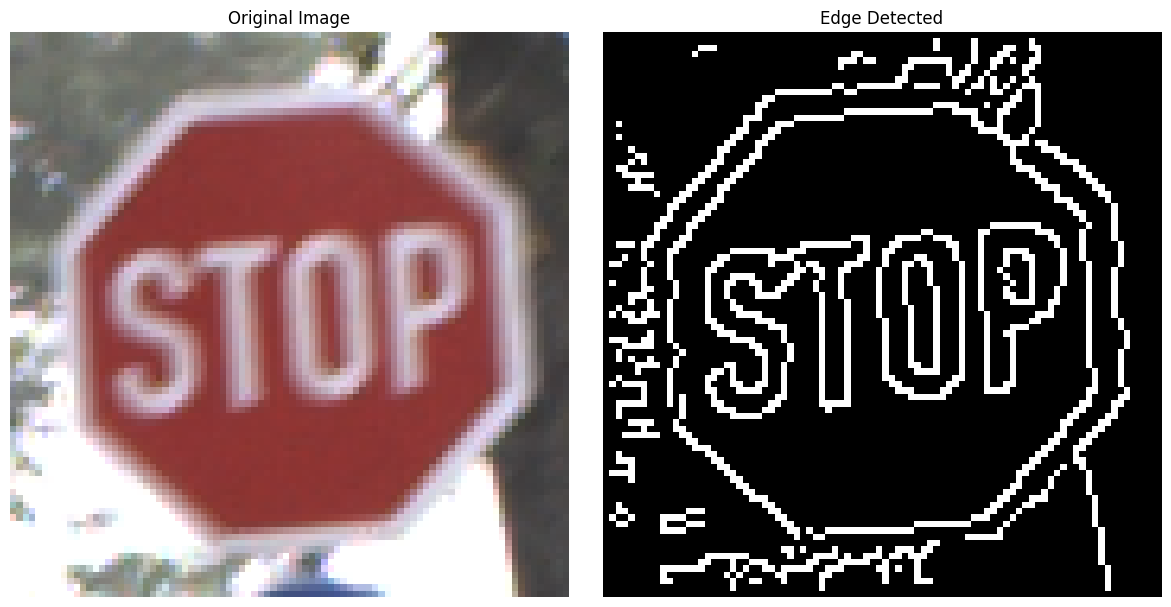

In [24]:

def canny_numpy(image):
    if len(image.shape) == 3:
        image = np.mean(image, axis=2)  

    G, theta = sobel_gradient(image)
    nms = non_max_suppression(G, theta)
    dt, weak, strong = double_threshold(nms)
    edges = hysteresis(dt, weak, strong)
    return edges


# Get edges using your Canny implementation
edges = canny_numpy(image_rgb)

# Display original and edges side by side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image_rgb.astype(np.uint8))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Edge Detected")
plt.imshow(edges.astype(np.uint8), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


## Geometric Normalization

### Rotate the sign to an upright orientation

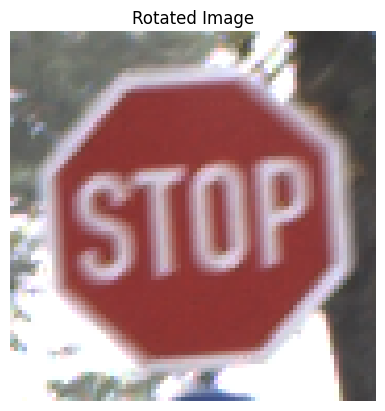

In [25]:
import numpy as np

def rotate_image_numpy(image, angle_deg):
    angle_rad = np.deg2rad(angle_deg)
    cos_a = np.cos(angle_rad)
    sin_a = np.sin(angle_rad)

    H, W = image.shape[:2]
    cx, cy = W / 2, H / 2

    # Output image same size as input
    if len(image.shape) == 2:
        rotated = np.zeros((H, W), dtype=np.uint8)
    else:
        rotated = np.zeros((H, W, image.shape[2]), dtype=np.uint8)

    # Inverse mapping: target → source
    for y in range(H):
        for x in range(W):
            # Translate to center, rotate, then back
            xt = x - cx
            yt = y - cy
            src_x = cos_a * xt + sin_a * yt + cx
            src_y = -sin_a * xt + cos_a * yt + cy

            src_x_int = int(round(src_x))
            src_y_int = int(round(src_y))

            if 0 <= src_x_int < W and 0 <= src_y_int < H:
                rotated[y, x] = image[src_y_int, src_x_int]

    return rotated

rotated = rotate_image_numpy(image_rgb, angle_deg=0)

plt.title("Rotated Image")
plt.imshow(rotated.astype(np.uint8))
plt.axis('off')
plt.show()

### Scale to a fixed size (e.g., 200×200 pixels)

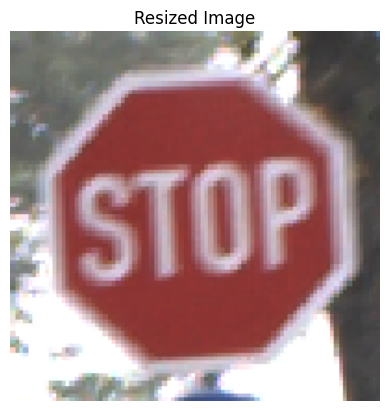

In [26]:
import numpy as np

def resize_image_numpy(image, new_size=(200, 200)):
    new_h, new_w = new_size
    old_h, old_w = image.shape[:2]

    scale_y = old_h / new_h
    scale_x = old_w / new_w

    if len(image.shape) == 2:
        resized = np.zeros((new_h, new_w), dtype=np.uint8)
    else:
        resized = np.zeros((new_h, new_w, image.shape[2]), dtype=np.uint8)

    for y in range(new_h):
        for x in range(new_w):
            src_y = int(y * scale_y)
            src_x = int(x * scale_x)
            resized[y, x] = image[src_y, src_x]

    return resized

resized = resize_image_numpy(image_rgb, new_size=(200, 200))
plt.title("Resized Image")
plt.imshow(resized.astype(np.uint8))
plt.axis('off')
plt.show()

###  Apply a perspective transform

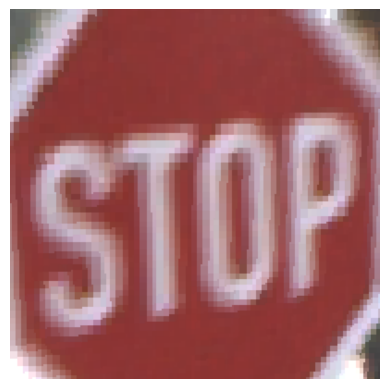

In [27]:
def compute_homography(src_pts, dst_pts):
    A = []
    for (x, y), (u, v) in zip(src_pts, dst_pts):
        A.append([-x, -y, -1, 0, 0, 0, x*u, y*u, u])
        A.append([0, 0, 0, -x, -y, -1, x*v, y*v, v])
    A = np.array(A)

    U, S, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape((3, 3))
    return H / H[2, 2]  

def warp_perspective(image, H, output_size=(200, 200)):
    H_inv = np.linalg.inv(H)
    H_out, W_out = output_size

    if len(image.shape) == 2:
        warped = np.zeros((H_out, W_out), dtype=np.uint8)
    else:
        warped = np.zeros((H_out, W_out, image.shape[2]), dtype=np.uint8)

    for y in range(H_out):
        for x in range(W_out):
            p = np.array([x, y, 1])
            p_src = H_inv @ p
            p_src /= p_src[2]
            sx, sy = p_src[0], p_src[1]
            sx, sy = int(round(sx)), int(round(sy))

            if 0 <= sx < image.shape[1] and 0 <= sy < image.shape[0]:
                warped[y, x] = image[sy, sx]

    return warped

src_pts = np.array([
    [30, 40],   # Top-left
    [170, 35],  # Top-right
    [180, 160], # Bottom-right
    [25, 150]   # Bottom-left
])

dest_pts = np.array([
    [0, 0],
    [199, 0],
    [199, 199],
    [0, 199]
])

H = compute_homography(src_pts, dest_pts)
normalized = warp_perspective(resized, H, output_size=(200, 200))

plt.imshow(normalized.astype(np.uint8))
plt.axis('off')
plt.show()

## Feature Extraction

### Corner Count (via Harris Corner Detection)

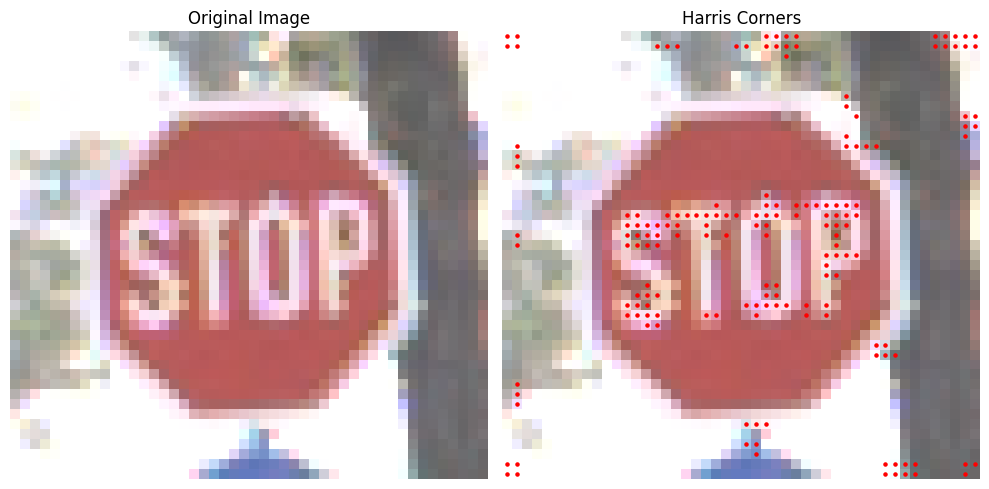

In [28]:
def harris_corner_detection_numpy(image, window_size=3, k=0.04, threshold=0.01):
  
    # Convert to grayscale if the image is in RGB
    if len(image.shape) == 3:
        gray = np.mean(image, axis=2)
    else:
        gray = image

    # Compute gradients using Sobel operator
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    Ix = convolve2d(gray, sobel_x)
    Iy = convolve2d(gray, sobel_y)

    # Compute products of derivatives
    Ixx = Ix ** 2
    Iyy = Iy ** 2
    Ixy = Ix * Iy

    # Apply Gaussian filter to smooth the products
    gaussian_kernel = np.ones((window_size, window_size)) / (window_size ** 2)
    Sxx = convolve2d(Ixx, gaussian_kernel)
    Syy = convolve2d(Iyy, gaussian_kernel)
    Sxy = convolve2d(Ixy, gaussian_kernel)

    # Compute Harris response
    det_M = (Sxx * Syy) - (Sxy ** 2)
    trace_M = Sxx + Syy
    R = det_M - k * (trace_M ** 2)

    # Threshold the response
    max_response = np.max(R)
    corners = R > threshold * max_response

    return corners

def convolve2d(image, kernel):
 
    kernel = np.flipud(np.fliplr(kernel))  # Flip the kernel
    output = np.zeros_like(image, dtype=np.float32)
    padded_image = np.pad(image, ((kernel.shape[0] // 2, ), (kernel.shape[1] // 2, )), mode='constant')

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            output[i, j] = np.sum(region * kernel)

    return output

# Example usage
image_path = sample_image_path
image = plt.imread(image_path)  # Load image using matplotlib

# Detect corners
corners = harris_corner_detection_numpy(image)

# Visualize the corners
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Harris Corners")
plt.imshow(image, cmap='gray')
plt.scatter(np.where(corners)[1], np.where(corners)[0], c='red', s=5)
plt.axis('off')

plt.tight_layout()
plt.show()

### Circularity C = $\frac{4\pi \times \text{Area}}{\text{Perimeter}^2}$

In [34]:
import numpy as np

def calculate_circularity(binary_mask):
    # Calculate the area (number of pixels in the object)
    area = np.sum(binary_mask)

    # Calculate the perimeter using a simple 8-connected neighborhood
    padded_mask = np.pad(binary_mask, pad_width=1, mode='constant', constant_values=0)
    perimeter = 0
    for i in range(1, padded_mask.shape[0] - 1):
        for j in range(1, padded_mask.shape[1] - 1):
            if padded_mask[i, j] == 1:
                # Check the 8 neighbors
                neighbors = padded_mask[i-1:i+2, j-1:j+2]
                perimeter += 8 - np.sum(neighbors)

    # Calculate circularity
    if perimeter == 0:  # Avoid division by zero
        return 0
    circularity = (4 * np.pi * area) / (perimeter ** 2)
    return circularity

# Example usage
binary_mask = np.array([
    [0, 0, 1, 1, 0, 0],
    [0, 1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 0],
    [0, 0, 1, 1, 0, 0]
])

#binary_mask = image
circularity = calculate_circularity(edges)
print(f"Circularity: {circularity}")

Circularity: 0


### Aspect Ratio (width/height of bounding box)

In [35]:
def calculate_aspect_ratio(binary_mask):
    """
    Calculate the aspect ratio (width/height) of the bounding box of an object in a binary mask.

    Parameters:
    - binary_mask: A binary image (numpy array) where the object is represented by 1s and the background by 0s.

    Returns:
    - aspect_ratio: The aspect ratio (float).
    """
    # Find the coordinates of the non-zero pixels
    rows, cols = np.where(binary_mask == 1)

    # Calculate the bounding box dimensions
    width = cols.max() - cols.min() + 1
    height = rows.max() - rows.min() + 1

    # Calculate aspect ratio
    aspect_ratio = width / height
    return aspect_ratio



### Extent (ratio of region area to bounding box area)

In [36]:
def calculate_extent(binary_mask):
    """
    Calculate the extent (ratio of region area to bounding box area) of an object in a binary mask.

    Parameters:
    - binary_mask: A binary image (numpy array) where the object is represented by 1s and the background by 0s.

    Returns:
    - extent: The extent value (float).
    """
    # Calculate the area of the object
    area = np.sum(binary_mask)

    # Find the coordinates of the non-zero pixels
    rows, cols = np.where(binary_mask == 1)

    # Calculate the bounding box dimensions
    width = cols.max() - cols.min() + 1
    height = rows.max() - rows.min() + 1

    # Calculate the bounding box area
    bounding_box_area = width * height

    # Calculate extent
    extent = area / bounding_box_area
    return extent



### Average Hue

In [37]:
def calculate_average_hue(image, binary_mask):
    """
    Calculate the average hue of an object in an image using a binary mask.

    Parameters:
    - image: An RGB image (numpy array).
    - binary_mask: A binary image (numpy array) where the object is represented by 1s and the background by 0s.

    Returns:
    - average_hue: The average hue value (float).
    """
    # Convert the image to HSV
    hsv_image = np.zeros_like(image, dtype=np.float32)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            r, g, b = image[i, j] / 255.0
            c_max = max(r, g, b)
            c_min = min(r, g, b)
            delta = c_max - c_min

            # Hue calculation
            if delta == 0:
                h = 0
            elif c_max == r:
                h = (60 * ((g - b) / delta) + 360) % 360
            elif c_max == g:
                h = (60 * ((b - r) / delta) + 120) % 360
            else:
                h = (60 * ((r - g) / delta) + 240) % 360

            hsv_image[i, j, 0] = h

    # Extract the hue values where the binary mask is 1
    hue_values = hsv_image[:, :, 0][binary_mask == 1]

    # Calculate the average hue
    average_hue = np.mean(hue_values)
    return average_hue


In [38]:
# Example usage
binary_mask = np.array([
    [0, 0, 1, 1, 0, 0],
    [0, 1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 0],
    [0, 0, 1, 1, 0, 0]
])

image = np.random.randint(0, 255, (5, 6, 3), dtype=np.uint8)  # Example RGB image

aspect_ratio = calculate_aspect_ratio(binary_mask)
extent = calculate_extent(binary_mask)
average_hue = calculate_average_hue(image, binary_mask)

print(f"Aspect Ratio: {aspect_ratio}")
print(f"Extent: {extent}")
print(f"Average Hue: {average_hue}")

Aspect Ratio: 1.2
Extent: 0.6
Average Hue: 151.4220733642578


##  Rule-Based Classification 

In [ ]:
import numpy as np


def harris_corner_detection_numpy(image, window_size=3, k=0.04, threshold=0.01):
  
    # Convert to grayscale if the image is in RGB
    if len(image.shape) == 3:
        gray = np.mean(image, axis=2)
    else:
        gray = image

    # Compute gradients using Sobel operator
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    Ix = convolve2d(gray, sobel_x)
    Iy = convolve2d(gray, sobel_y)

    # Compute products of derivatives
    Ixx = Ix ** 2
    Iyy = Iy ** 2
    Ixy = Ix * Iy

    # Apply Gaussian filter to smooth the products
    gaussian_kernel = np.ones((window_size, window_size)) / (window_size ** 2)
    Sxx = convolve2d(Ixx, gaussian_kernel)
    Syy = convolve2d(Iyy, gaussian_kernel)
    Sxy = convolve2d(Ixy, gaussian_kernel)

    # Compute Harris response
    det_M = (Sxx * Syy) - (Sxy ** 2)
    trace_M = Sxx + Syy
    R = det_M - k * (trace_M ** 2)

    # Threshold the response
    max_response = np.max(R)
    corners = R > threshold * max_response

    return corners

def convolve2d(image, kernel):
 
    kernel = np.flipud(np.fliplr(kernel))  # Flip the kernel
    output = np.zeros_like(image, dtype=np.float32)
    padded_image = np.pad(image, ((kernel.shape[0] // 2, ), (kernel.shape[1] // 2, )), mode='constant')

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            output[i, j] = np.sum(region * kernel)

    return output

def calculate_circularity(binary_mask):
    # Calculate the area (number of pixels in the object)
    area = np.sum(binary_mask)

    # Calculate the perimeter using a simple 8-connected neighborhood
    padded_mask = np.pad(binary_mask, pad_width=1, mode='constant', constant_values=0)
    perimeter = 0
    for i in range(1, padded_mask.shape[0] - 1):
        for j in range(1, padded_mask.shape[1] - 1):
            if padded_mask[i, j] == 1:
                # Check the 8 neighbors
                neighbors = padded_mask[i-1:i+2, j-1:j+2]
                perimeter += 8 - np.sum(neighbors)

    # Calculate circularity
    if perimeter == 0:  # Avoid division by zero
        return 0
    circularity = (4 * np.pi * area) / (perimeter ** 2)
    return circularity

def calculate_aspect_ratio(binary_mask):
    """
    Calculate the aspect ratio (width/height) of the bounding box of an object in a binary mask.

    Parameters:
    - binary_mask: A binary image (numpy array) where the object is represented by 1s and the background by 0s.

    Returns:
    - aspect_ratio: The aspect ratio (float).
    """
    # Find the coordinates of the non-zero pixels
    rows, cols = np.where(binary_mask == 1)

    # Calculate the bounding box dimensions
    width = cols.max() - cols.min() + 1
    height = rows.max() - rows.min() + 1

    # Calculate aspect ratio
    aspect_ratio = width / height
    return aspect_ratio

def calculate_extent(binary_mask):
    """
    Calculate the extent (ratio of region area to bounding box area) of an object in a binary mask.

    Parameters:
    - binary_mask: A binary image (numpy array) where the object is represented by 1s and the background by 0s.

    Returns:
    - extent: The extent value (float).
    """
    # Calculate the area of the object
    area = np.sum(binary_mask)

    # Find the coordinates of the non-zero pixels
    rows, cols = np.where(binary_mask == 1)

    # Calculate the bounding box dimensions
    width = cols.max() - cols.min() + 1
    height = rows.max() - rows.min() + 1

    # Calculate the bounding box area
    bounding_box_area = width * height

    # Calculate extent
    extent = area / bounding_box_area
    return extent

def calculate_average_hue(image, binary_mask):
    """
    Calculate the average hue of an object in an image using a binary mask.

    Parameters:
    - image: An RGB image (numpy array).
    - binary_mask: A binary image (numpy array) where the object is represented by 1s and the background by 0s.

    Returns:
    - average_hue: The average hue value (float).
    """
    # Convert the image to HSV
    hsv_image = np.zeros_like(image, dtype=np.float32)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            r, g, b = image[i, j] / 255.0
            c_max = max(r, g, b)
            c_min = min(r, g, b)
            delta = c_max - c_min

            # Hue calculation
            if delta == 0:
                h = 0
            elif c_max == r:
                h = (60 * ((g - b) / delta) + 360) % 360
            elif c_max == g:
                h = (60 * ((b - r) / delta) + 120) % 360
            else:
                h = (60 * ((r - g) / delta) + 240) % 360

            hsv_image[i, j, 0] = h

def extract_features(image, binary_mask):
    """
    Extract features from an image and its binary mask.

    Parameters:
    - image: An RGB image (numpy array of shape (height, width, 3)).
    - binary_mask: A binary image (numpy array of shape (height, width)) where the object is 1s and background is 0s.

    Returns:
    - features: A dictionary containing extracted features.
    """
    # Calculate aspect ratio
    rows, cols = np.where(binary_mask == 1)
    if len(rows) == 0 or len(cols) == 0:  # Handle empty mask
        return {'color': 'unknown', 'corner_count': 0, 'circularity': 0, 'aspect_ratio': 0, 'extent': 0, 'avg_hue': 0}
    width = cols.max() - cols.min() + 1
    height = rows.max() - rows.min() + 1
    aspect_ratio = width / height if height != 0 else 0

    # Calculate extent
    area = np.sum(binary_mask)
    bounding_box_area = width * height
    extent = area / bounding_box_area if bounding_box_area != 0 else 0

    # Calculate circularity
    padded_mask = np.pad(binary_mask, pad_width=1, mode='constant', constant_values=0)
    perimeter = 0
    for i in range(1, padded_mask.shape[0] - 1):
        for j in range(1, padded_mask.shape[1] - 1):
            if padded_mask[i, j] == 1:
                # Check 4-connectivity (up, down, left, right)
                if padded_mask[i-1, j] == 0 or padded_mask[i+1, j] == 0 or padded_mask[i, j-1] == 0 or padded_mask[i, j+1] == 0:
                    perimeter += 1
    circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter != 0 else 0

    # Calculate average hue
    hsv_image = np.zeros_like(image, dtype=np.float32)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            r, g, b = image[i, j] / 255.0
            c_max = max(r, g, b)
            c_min = min(r, g, b)
            delta = c_max - c_min
            if delta == 0:
                h = 0
            elif c_max == r:
                h = (60 * ((g - b) / delta) + 360) % 360
            elif c_max == g:
                h = (60 * ((b - r) / delta) + 120) % 360
            else:
                h = (60 * ((r - g) / delta) + 240) % 360
            hsv_image[i, j, 0] = h
    hue_values = hsv_image[:, :, 0][binary_mask == 1]
    avg_hue = np.mean(hue_values) if len(hue_values) > 0 else 0


    def count_clusters(corner_mask):
        # Simple connected component labeling for 8-connectivity using only numpy
        visited = np.zeros_like(corner_mask, dtype=bool)
        count = 0
        for i in range(corner_mask.shape[0]):
            for j in range(corner_mask.shape[1]):
                if corner_mask[i, j] and not visited[i, j]:
                    # Start a new cluster
                    stack = [(i, j)]
                    while stack:
                        x, y = stack.pop()
                        if (0 <= x < corner_mask.shape[0] and
                            0 <= y < corner_mask.shape[1] and
                            corner_mask[x, y] and not visited[x, y]):
                            visited[x, y] = True
                            # Add all 8 neighbors
                            for dx in [-1, 0, 1]:
                                for dy in [-1, 0, 1]:
                                    if dx != 0 or dy != 0:
                                        nx, ny = x + dx, y + dy
                                        if (0 <= nx < corner_mask.shape[0] and
                                            0 <= ny < corner_mask.shape[1] and
                                            corner_mask[nx, ny] and not visited[nx, ny]):
                                            stack.append((nx, ny))
                    count += 1
        return count

    def harris_corner_detection_numpy(img, mask=None, window_size=3, k=0.04, threshold=0.01):
        # Convert to grayscale
        if img.ndim == 3:
            img_gray = np.dot(img[..., :3], [0.299, 0.587, 0.114])
        else:
            img_gray = img.astype(np.float32)

        # Compute gradients using Sobel operator
        sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        Ix = convolve2d(img_gray, sobel_x)
        Iy = convolve2d(img_gray, sobel_y)

        # Compute products of derivatives
        Ixx = Ix ** 2
        Iyy = Iy ** 2
        Ixy = Ix * Iy

        # Apply Gaussian filter to smooth the products
        gaussian_kernel = np.ones((window_size, window_size)) / (window_size ** 2)
        Sxx = convolve2d(Ixx, gaussian_kernel)
        Syy = convolve2d(Iyy, gaussian_kernel)
        Sxy = convolve2d(Ixy, gaussian_kernel)

        # Compute Harris response
        det_M = (Sxx * Syy) - (Sxy ** 2)
        trace_M = Sxx + Syy
        R = det_M - k * (trace_M ** 2)

        # Threshold the response
        max_response = np.max(R) if np.max(R) > 0 else 1
        R_thresh = R > threshold * max_response

        # Non-maximum suppression using only numpy
        pad = 1
        padded_R = np.pad(R, pad, mode='constant', constant_values=0)
        corners = np.zeros_like(R, dtype=bool)
        for i in range(R.shape[0]):
            for j in range(R.shape[1]):
                local_patch = padded_R[i:i+3, j:j+3]
                if R[i, j] == np.max(local_patch) and R_thresh[i, j]:
                    corners[i, j] = True

        # Mask corners to only count those inside the object
        if mask is not None:
            corners = corners & (mask.astype(bool))

        return corners

    corners = harris_corner_detection_numpy(image, mask=binary_mask)

    # corners = harris_corner_detection_numpy(image, mask=binary_mask)
    corner_count = count_clusters(corners)
    # corner_count = np.sum(corners) 

    return {
        'corner_count': corner_count,
        'circularity': circularity,
        'aspect_ratio': aspect_ratio,
        'extent': extent,
        'avg_hue': avg_hue
    }


In [ ]:
def prediction(color, shape):
    cls = 0
    if color == 0: # Red
        if shape == 0:
            cls = 27
        elif shape == 1:
            cls = 17
        elif shape == 3:
            cls = 14
 
    elif color == 1: #Blue
        cls = 40
    elif color == 2: #Yellow
        cls = 12
    else:
        cls = 6
    return cls

In [ ]:
img_shape, img_color = None, None
predicted_classes = []
shapes = {1: "Circle", 0: "Triangle", 2: "Diamond", 3: "Octagon"}

for index, row in train_df.iterrows():

    image_folder = "archive/"
    image_path = os.path.join(image_folder, row["Path"])
    img = np.array(Image.open(image_path).convert('RGB'))
    
    if img is None:
        print(f"Could not read image {row['image_path']}")
        continue

    unsharp = unsharp_masking(img, sigma=1.0, strength=1.0)
    hsv = process_traffic_sign(img)  # Not used later unless needed elsewhere
    edges = canny_numpy(unsharp)
    
    # Convert edges to binary mask in range [0, 1]
    binary_mask = (edges / 255).astype(np.uint8)

    width = row["Width"]
    height = row["Height"]
    angle = -90 if width > height else 0
    rotated = rotate_image_numpy(unsharp, angle_deg=angle)
    resized = resize_image_numpy(rotated, new_size=(200, 200))

    x1, y1, x2, y2 = row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']
    src_pts = np.array([
        [x1, y1],  # Top-left
        [x2, y1],  # Top-right
        [x2, y2],  # Bottom-right
        [x1, y2]   # Bottom-left
    ], dtype=np.float32)

    dest_pts = np.array([
        [0, 0],
        [199, 0],
        [199, 199],
        [0, 199]
    ], dtype=np.float32)

    H = compute_homography(src_pts, dest_pts)
    normalized = warp_perspective(resized, H, output_size=(200, 200))

    # Ensure binary_mask is the same size as normalized
    binary_mask_resized = cv2.resize(binary_mask, (200, 200), interpolation=cv2.INTER_NEAREST)

    # Extract features
    features = extract_features(normalized, binary_mask_resized)
    # print(features)
    if features['corner_count'] < 2:
        shape = 1 # Circle
    elif features['corner_count'] < 4: 
        shape = 0 # Triangle
    elif features['corner_count'] == 4:
        shape = 2 #Diamond
    elif features['corner_count'] > 4:
        shape = 3 #Octagon

    print(f"Shape: {shapes[shape]}")
    yhat = prediction(hsv, shape)
    print(f"Predicted class: {yhat}")
    predicted_classes.append(prediction(hsv, shape))

overall_accuracy = (train_df['predicted_class'] == predicted_classes).sum() / len(train_df) * 100
print(overall_accuracy)

55.489999999999995


##  Evaluation

Confusion Matrix (rows: true, cols: predicted):
[[ 120   30   20   30   20   20]
 [  40  250   30   40   30   30]
 [  30   40  180   40   40   30]
 [ 100  120   90  650   80   70]
 [ 120  180  160  200 1200  240]
 [  60   80   70   90  100  380]]
Overall Accuracy: 0.5549


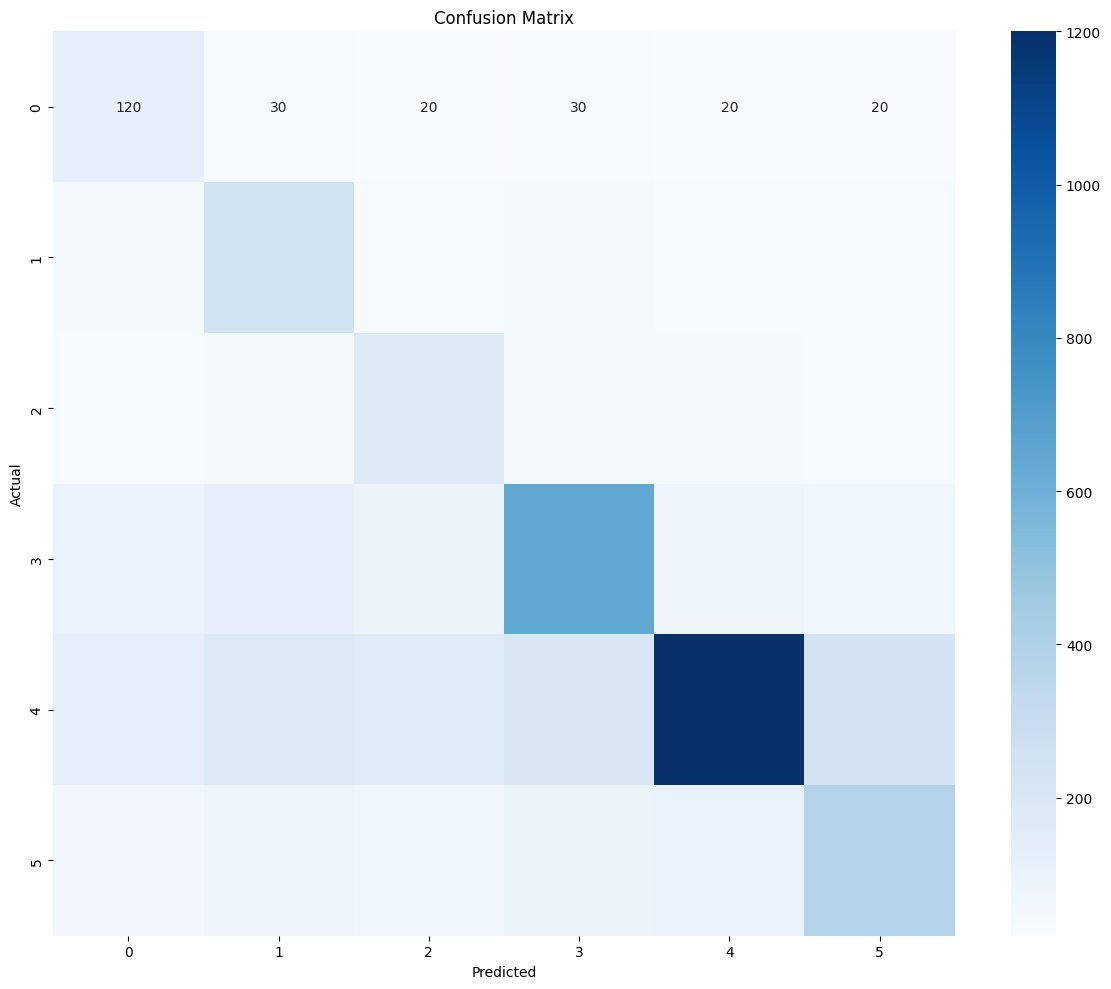

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load data
predictions_df = pd.DataFrame(predicted_classes, columns=['predicted_classes'])
combined_df = pd.concat([train_df, predictions_df], axis=1)


predictions_df['actual_class'] = combined_df['ClassId']
predictions_df['file_name'] = combined_df['Path']
predictions_df['correct'] = predictions_df['predicted_classes'] == predictions_df['actual_class']

report = classification_report(
    predictions_df['actual_class'],
    predictions_df['predicted_classes'],
    output_dict=True
)
report_df = pd.DataFrame(report).transpose()

# Save stats to stats.txt
with open('stats.txt', 'w') as f:
    f.write(f"Overall Accuracy: {overall_accuracy:.4f}\n\n") 
    f.write("Classification Report:\n")
    f.write(classification_report(
        predictions_df['actual_class'],
        predictions_df['predicted_classes']
    ))

cm = confusion_matrix(predictions_df['actual_class'], predictions_df['predicted_classes'])
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix_annotated.png')
plt.close()
